First we are going to load the data.

In [4]:
import csv
import pandas as pd

In [5]:
data = pd.read_csv("./../data/in_silico_growth_curve.csv")

Let's see what the datafile contents are.

In [6]:
data

,times,cells
0,0.000000,8677.144668
1,1.500000,26920.855990
2,3.000000,63176.862474
3,4.500000,249712.054657
4,6.000000,442178.369581
5,7.500001,802923.563655
6,9.000001,875907.621559
7,10.500001,856617.310790
8,12.000001,885705.601724
9,13.500001,912408.715922


It's a very small dataset with just 10 time points showing the number of cells over time. With these short time series, both having a mechanistic model to fit it and having a Bayesian framework to do so helps us to make better sense of the science behind the process. We can visualize the data as.

Text(0, 0.5, 'cells')

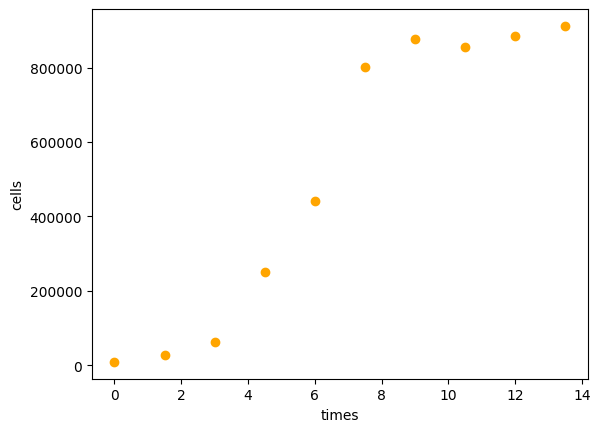

In [7]:
import matplotlib.pyplot as plt
plt.plot(data['times'],data['cells'],'o',color ='orange')
plt.xlabel(data.columns[0])
plt.ylabel(data.columns[1])


However that can be complicated, let's start with the most simple way of fitting a nonlinear ODE model to the data.

### Use of Biological Mechanistic knowledge.
This data is a growth data of the cells where they consume nutrients and we can use the blahblah model

$$
\frac{dN}{dt} = -Q_n \frac{\mu_{max}N}{N+K_s}(P\times10^6)
$$

$$
\frac{dP}{dt} = \frac{\mu_{max}N}{N+K_s} P
$$

### In this dataset the variable 'N' (nutrients) is latent (unobserved)

In [8]:
import numpy as np
from scipy.integrate import odeint
t = np.linspace(0, 15, 100)

def cells_grow(y,t,mu_max,Ks,Qn):
    N, P = y
    dydt = [0,0]
    dydt[0] = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dydt[1] = P*(mu_max*N)/(N+Ks)

    return dydt

def solved_num_cells(y0,t,mu_max,Ks,Qn):
    sol = odeint(cells_grow, y0, t, args=(mu_max,Ks,Qn))
    return sol[:,1]

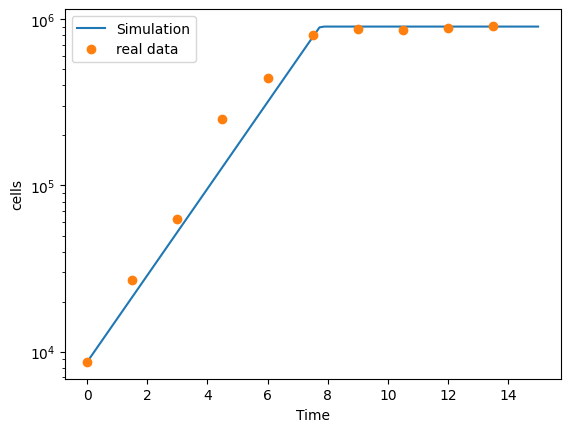

In [9]:
mu_max = 0.6
Ks = 0.09
Qn = 6.7e-10

y0 = [ 6e2, data['cells'][0] ]
num_cells_solved = solved_num_cells(y0,t,mu_max,Ks,Qn)

plt.plot(t,num_cells_solved)
plt.plot(data['times'],data['cells'],'o')
plt.yscale('log')
plt.legend(['Simulation','real data'])
plt.xlabel('Time')
plt.ylabel('cells')
plt.show()


### Using pymc

In [10]:
import pymc as pm

In [11]:
!pip install numba
from numba import njit


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [13]:
@njit
def cells_grow_pymc(y,t,theta):
    # unpack parameters
    N, P = y
    mu_max,Ks,Qn = theta
    
    dp_dt = -Qn*(mu_max*N)/(N+Ks) *(P*1e6)
    dq_dt = P*(mu_max*N)/(N+Ks)

    return [dp_dt, dq_dt]

y0 = [ 6e2, data['cells'][0] ]

In [14]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func = cells_grow_pymc, y0=[ 6e2, data['cells'][0] ], t=data['times'], args=(theta,))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [mu_max]
>>Slice: [Ks]
>>Slice: [Qn]
>NUTS: [sigma]


Output()

/var/folders/qg/yrfyy1y96_z1x70d4q3n5j3h013035/T/ipykernel_2007/2235747985.py:4: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func = cells_grow_pymc, y0=[ 6e2, data['cells'][0] ], t=data['times'], args=(theta,))
/var/folders/qg/yrfyy1y96_z1x70d4q3n5j3h013035/T/ipykernel_2007/2235747985.py:4: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func = cells_grow_pymc, y0=[ 6e2, data['cells'][0] ], t=data['times'], args=(theta,))
/var/folders/qg/yrfyy1y96_z1x70d4q3n5j3h013035/T/ipykernel_2007/2235747985.py:4: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  return odeint(func = cells_grow_pymc, y0=[ 6e2, data['cells'][0] ], t=data['times'], args=(theta,))
/var/folders/qg/yrfyy1y96_z1x70d4q3n5j3h013035/T/ipykernel_20

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5855524365031D+01   r2 =  0.4423095443586D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5855524365031D+01   r2 =  0.1105773860897D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5855524365031D+01   r2 =  0.1105773860897D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5855524365031D+01   r2 =  0.1105773860897D-15
 lsoda--  warning..internal t (=r1) 

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ks,0.090,0.010,0.071,0.108,0.000,0.000,7732.0,5925.0,1.0
Qn,0.000,0.000,0.000,0.000,0.000,0.000,7431.0,4944.0,1.0
mu_max,0.684,0.019,0.647,0.720,0.000,0.000,7364.0,4653.0,1.0
sigma,0.154,0.049,0.083,0.239,0.001,0.001,2330.0,2578.0,1.0


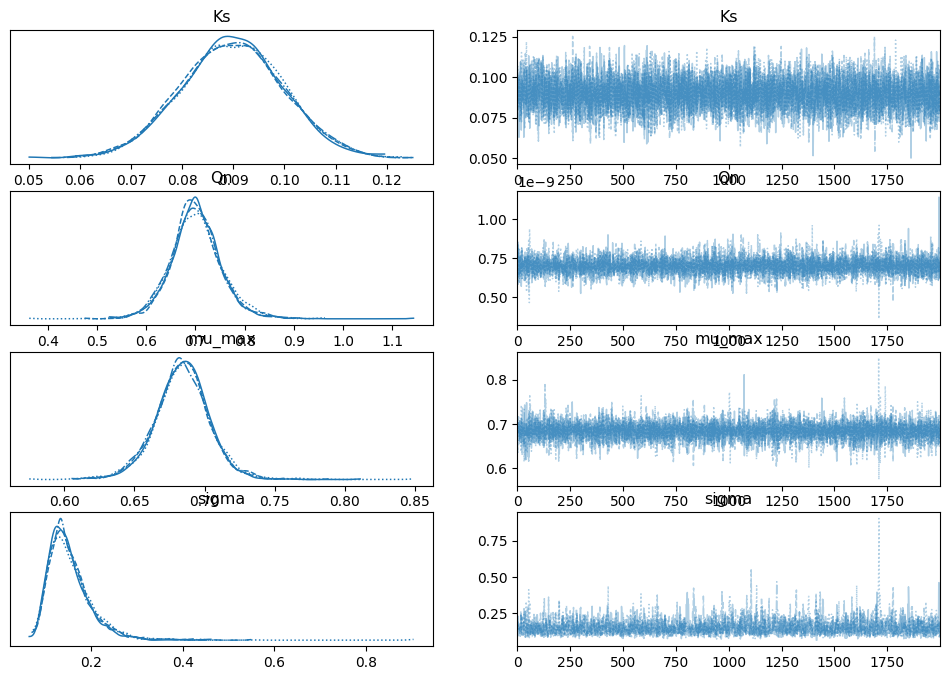

In [17]:
with pm.Model() as model:
    # Priors
    
    
    # Priors
    mu_max = pm.Normal('mu_max', mu=0.6, sigma=0.1)
    Ks = pm.Normal('Ks', mu=0.09, sigma=0.01)
    Qn = pm.Lognormal('Qn', mu=np.log(6.7e-10), sigma=1.0)
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([mu_max,Ks,Qn])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=np.log(ode_solution[:,1]), sigma=sigma, observed= np.log(data['cells'].values))


    # Sampling
    trace = pm.sample(2000, tune=1000)


# Summarize results
az.plot_trace(trace)
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ks,0.090,0.010,0.071,0.108,0.000,0.000,7732.0,5925.0,1.0
Qn,0.000,0.000,0.000,0.000,0.000,0.000,7431.0,4944.0,1.0
mu_max,0.684,0.019,0.647,0.720,0.000,0.000,7364.0,4653.0,1.0
sigma,0.154,0.049,0.083,0.239,0.001,0.001,2330.0,2578.0,1.0


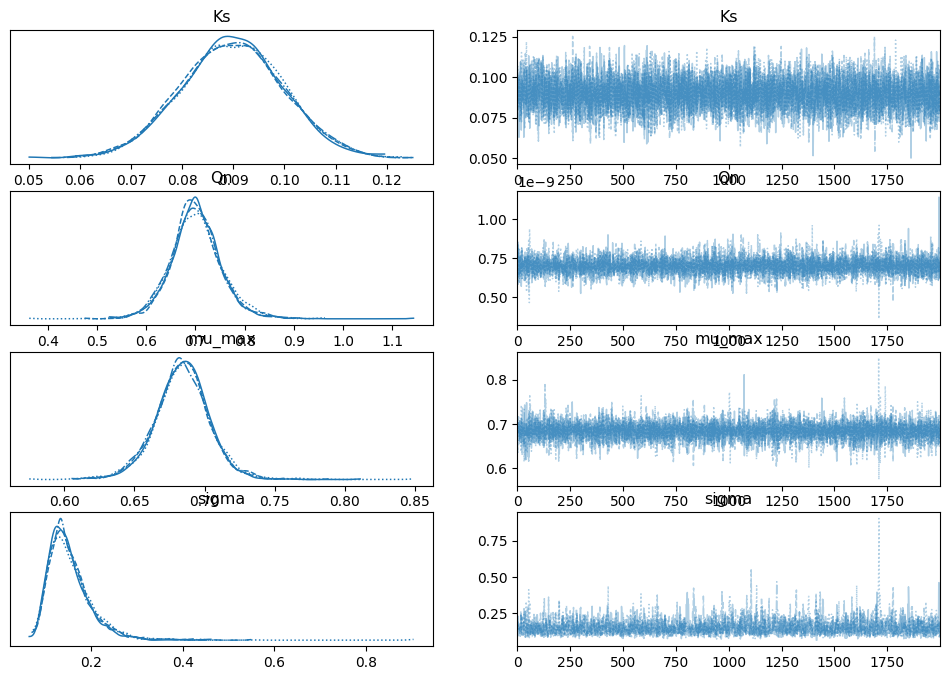

In [18]:
# Summarize results
az.plot_trace(trace)
az.summary(trace)

In [21]:
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [26]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["mu_max", "Ks", "Qn"]
    row = trace_df.iloc[row_idx, :][cols].values

    time = data['times']
    theta = row
    x_y = odeint(func= cells_grow_pymc, y0 = [ 6e2, data['cells'][0] ], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [34]:
def plot_inference(
    ax,
    trace,
    num_samples=200,
    title="Cell growth Bayesian fit",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

In [36]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="cells growth"):
    ax.plot(data['times'], data['cells'], color="k", lw=lw, marker="o", markersize=12, label="data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Cells", fontsize=14)
    ax.set_title(title, fontsize=16)
    return ax

In [40]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=data['times'],
    alpha=1,
    lw=3,
    title="bayesian",
):
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Bayesian")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    ax.set_yscale('log')
    return ax

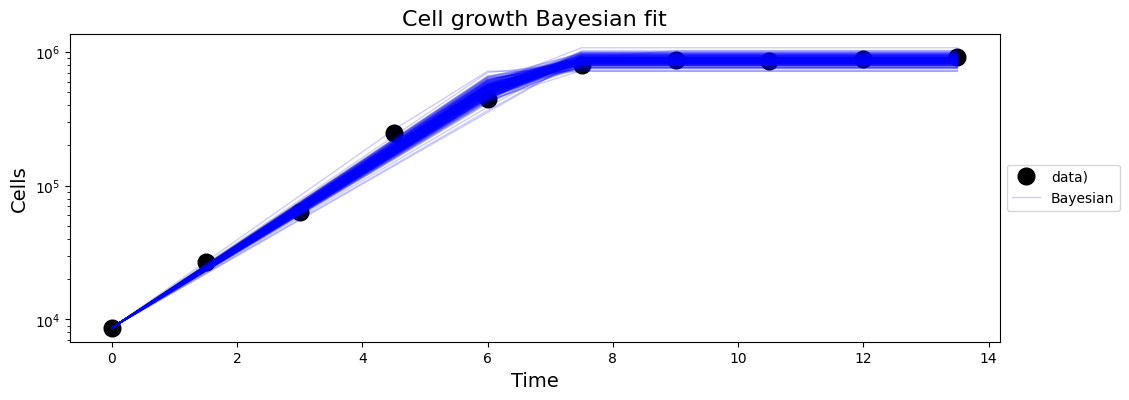

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace,num_samples=200);